In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, **kwargs):
        self.iteration = iteration
        super(SpectralNormalization, self).__init__(layer,**kwargs)
    
    def build(self, input_shape):
        super(SpectralNormalization, self).build(input_shape)
        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()
        self.u = self.add_weight(shape=(1, self.w_shape[-1]), 
                                 initializer =tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_u',
                                 dtype = tf.float32)
    
    def call(self, input_tensor, training=False):
        if training:
            self.update_weights()
        output = self.layer(input_tensor)
        return output

    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])

        u = self.u  
        for _ in range(self.iteration):
            v = tf.math.l2_normalize(tf.matmul(u, tf.transpose(w_reshaped)))
            u = tf.math.l2_normalize(tf.matmul(v, w_reshaped))

        sigma = tf.matmul(tf.matmul(v, w_reshaped), tf.transpose(u))
        self.u.assign(u)
        self.w.assign(self.w/sigma)

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 16

(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(2*2*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((2, 2, 512)))
    assert model.output_shape == (None, 2, 2, 512) # 주목: 배치사이즈로 None이 주어집니다
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


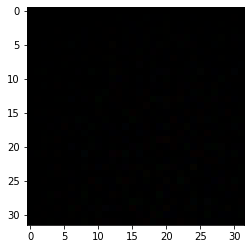

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[32,32,3])))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(SpectralNormalization(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(SpectralNormalization(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0002668]], shape=(1, 1), dtype=float32)


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [13]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)


        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)


In [15]:
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(tf.cast(predictions[i]*127.5+127.5,tf.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

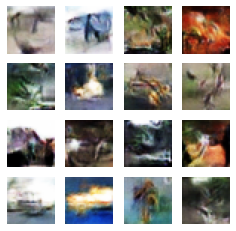

CPU times: user 1h 34min 19s, sys: 1min 18s, total: 1h 35min 38s
Wall time: 1h 41min 5s


In [16]:
%%time
train(train_dataset, 50)

In [17]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)